In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
from sqlalchemy import create_engine, inspect
engine = create_engine('sqlite:////content/drive/MyDrive/Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [4]:
from sqlalchemy import inspect
inspector = inspect(engine)
print(inspector.get_table_names())

['Earthquake_features', 'Earthquake_predict', 'dashboard_data']


In [ ]:
# df_features = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Earthquake_features.csv")

In [5]:
df_features.head()

,place,depth,mag,date,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,Italy,10.10,3.3,2015-03-04,41.657691,13.549476,52.355455,70.554667,78.654286,4.154545,4.140000,4.157143,1
1,Italy,17.30,4.2,2015-02-28,41.657691,13.549476,52.673636,67.328000,80.840000,4.190909,4.100000,4.257143,1
2,Italy,7.20,3.9,2015-02-18,41.657691,13.549476,52.637273,51.389333,76.154286,4.195455,4.086667,4.157143,1
3,Italy,245.41,4.8,2015-02-06,41.657691,13.549476,63.428636,57.859333,80.498571,4.263636,4.126667,4.171429,0
4,Italy,6.00,4.4,2015-01-30,41.657691,13.549476,62.296818,58.126000,78.370000,4.259091,4.153333,4.157143,0


In [ ]:
# df_predict = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Earthquake_predict.csv")

In [6]:
df_predict.head()

,place,depth,mag,date,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,Italy,10.000,4.2,2024-11-29,41.657691,13.549476,88.096955,64.526667,66.537143,4.140909,4.106667,4.071429,NaN
1,Italy,265.157,4.3,2024-11-15,41.657691,13.549476,99.695000,54.400200,79.585571,4.140909,4.113333,4.114286,NaN
2,Italy,10.000,4.0,2024-11-09,41.657691,13.549476,99.849273,53.694800,79.585571,4.136364,4.120000,4.114286,NaN
3,Italy,10.000,4.0,2024-10-28,41.657691,13.549476,81.691227,53.722867,75.513571,4.109091,4.160000,4.100000,NaN
4,Italy,10.000,3.9,2024-09-21,41.657691,13.549476,65.981227,53.722867,46.451000,4.090909,4.080000,4.057143,NaN


In [7]:
df_features['mag_outcome'].value_counts()

,count
mag_outcome,
1,113916
0,79793


In [8]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42, stratify=df_features['mag_outcome'])

In [9]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [11]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid,
                               scoring = 'roc_auc',
                               return_train_score=True,
                               verbose = 0)

In [12]:
grid_search_ABC.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc')

In [13]:
print(grid_search_ABC.best_params_)
print(grid_search_ABC.best_score_)
print(grid_search_ABC.best_estimator_)

{'estimator__max_depth': 5, 'n_estimators': 600}
0.9312863536642235
AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.6, n_estimators=600)


In [14]:
pred_ABC=grid_search_ABC.predict(X_test)

0.8769960669549715
AUC: 0.877


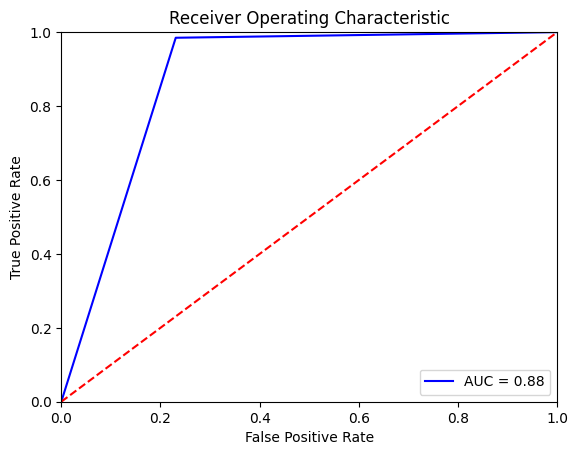

Confusion Matrix: 
 [[18414  5524]
 [  521 33654]]

Recall 'TP/TP+FN' =  0.9847549378200439


In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred_ABC))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred_ABC))

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_ABC))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     23938
           1       0.86      0.98      0.92     34175

    accuracy                           0.90     58113
   macro avg       0.92      0.88      0.89     58113
weighted avg       0.91      0.90      0.89     58113



In [17]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50)

param_grid = {
    'n_estimators': [200, 700],
    'max_features': ['sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [18]:
print(CV_rfc.best_params_ )
print(CV_rfc.best_score_)
print(CV_rfc.best_estimator_)

{'max_features': 'log2', 'n_estimators': 700}
0.9013097828091006
RandomForestClassifier(max_features='log2', n_estimators=700, n_jobs=-1)


In [19]:
pred=CV_rfc.predict(X_test)

0.8847028146290865
AUC: 0.8847


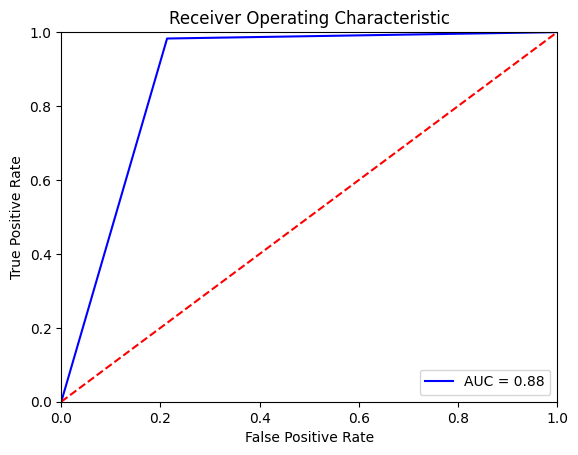

Confusion Matrix: 
 [[18832  5106]
 [  591 33584]]

Recall 'TP/TP+FN' =  0.982706656912948


In [20]:
print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred))

In [21]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     23938
           1       0.87      0.98      0.92     34175

    accuracy                           0.90     58113
   macro avg       0.92      0.88      0.90     58113
weighted avg       0.91      0.90      0.90     58113



In [ ]:
!pip install --upgrade xgboost

[0]	eval-auc:0.92930
[1]	eval-auc:0.92931
[2]	eval-auc:0.92930
[3]	eval-auc:0.92930
[4]	eval-auc:0.92951
[5]	eval-auc:0.92951
[6]	eval-auc:0.92974
[7]	eval-auc:0.92973
[8]	eval-auc:0.92972
[9]	eval-auc:0.92980
[10]	eval-auc:0.92977
[11]	eval-auc:0.92979
[12]	eval-auc:0.92976
[13]	eval-auc:0.92987
[14]	eval-auc:0.92982
[15]	eval-auc:0.92985
[16]	eval-auc:0.92982
[17]	eval-auc:0.92984
[18]	eval-auc:0.92984
[19]	eval-auc:0.92986
[20]	eval-auc:0.92987
[21]	eval-auc:0.92989
[22]	eval-auc:0.92991
[23]	eval-auc:0.92991
[24]	eval-auc:0.92991
[25]	eval-auc:0.92993
[26]	eval-auc:0.92992
[27]	eval-auc:0.92994
[28]	eval-auc:0.93004
[29]	eval-auc:0.93006
[30]	eval-auc:0.93007
[31]	eval-auc:0.93010
[32]	eval-auc:0.93007
[33]	eval-auc:0.93010
[34]	eval-auc:0.93009
[35]	eval-auc:0.93008
[36]	eval-auc:0.93007
[37]	eval-auc:0.93007
[38]	eval-auc:0.93008
[39]	eval-auc:0.93013
[40]	eval-auc:0.93013
[41]	eval-auc:0.93016
[42]	eval-auc:0.93018
[43]	eval-auc:0.93021
[44]	eval-auc:0.93024
[45]	eval-auc:0.9303

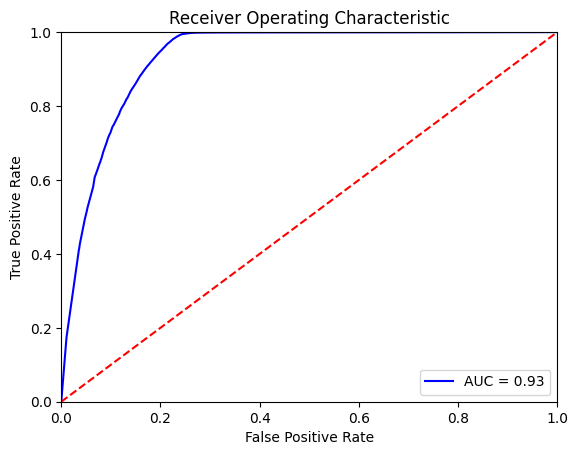

Confusion Matrix: 
 [[17530  6408]
 [   64 34111]]

Recall 'TP/TP+FN' =  0.9981272860277981


In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'verbosity': 0}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations
bst = xgb.train(param, dtrain, num_round, evals=[(dtest, 'eval')], early_stopping_rounds=10)
preds = bst.predict(dtest)

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

ypred_bst = np.array(bst.predict(dtest, iteration_range=(0, bst.best_iteration)))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Confusion Matrix: \n",confusion_matrix(y_test,ypred_bst))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,ypred_bst))

In [23]:
print(classification_report(y_test, ypred_bst))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     23938
           1       0.84      1.00      0.91     34175

    accuracy                           0.89     58113
   macro avg       0.92      0.87      0.88     58113
weighted avg       0.91      0.89      0.88     58113



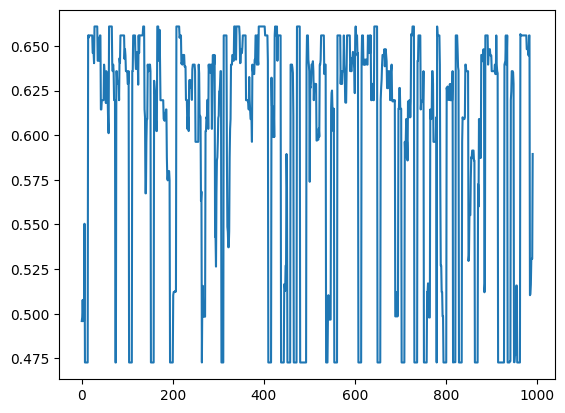

In [24]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

In [25]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
print(live_set.head())
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d')
live_set['date'] = live_set['date'] + pd.to_timedelta(365,unit='d')

live_set.tail()

         date  place   latitude  longitude
0  2024-11-29  Italy  41.657691  13.549476
1  2024-11-15  Italy  41.657691  13.549476
2  2024-11-09  Italy  41.657691  13.549476
3  2024-10-28  Italy  41.657691  13.549476
4  2024-09-21  Italy  41.657691  13.549476


/tmp/ipython-input-1266568166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  live_set.loc[:,'quake'] = preds


,date,place,latitude,longitude,quake
834,2025-12-24,Cyprus,34.966441,32.456730,0.532539
835,2025-12-30,Azerbaijan,40.473298,48.769663,0.655847
836,2025-12-30,Bonaire,17.310221,-64.028007,0.472889
837,2025-12-30,California,39.825299,-122.095788,0.472731
838,2025-12-31,Nepal,28.128111,85.188693,0.660866


In [26]:
import datetime as dt

# Convert to datetime
live_set['date'] = pd.to_datetime(live_set['date'])  # Ensure datetime64 dtype

# Get today's date as pandas Timestamp (no time component)
today = pd.Timestamp(dt.datetime.today().date())

# Filter future dates and extract as formatted string list
days = sorted(live_set[live_set['date'] > today]['date'].dt.strftime('%Y-%m-%d').unique())

# Access a prediction day safely
if len(days) > 2:
    predict_day = days[2]
    print(predict_day)
else:
    print("Not enough future dates available.")

2025-08-11


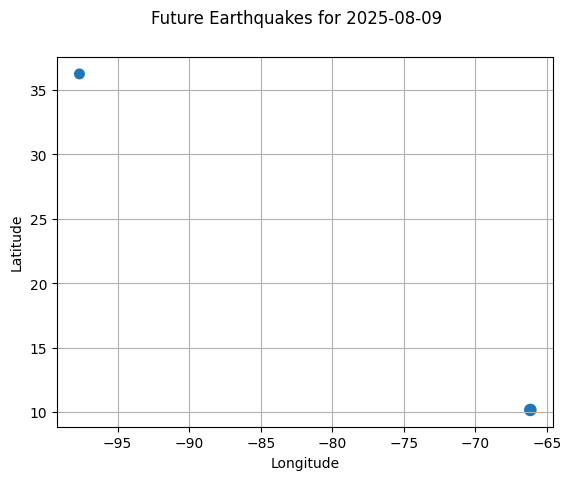

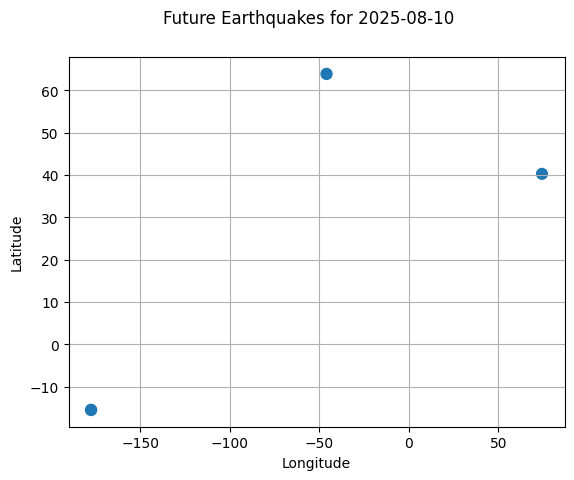

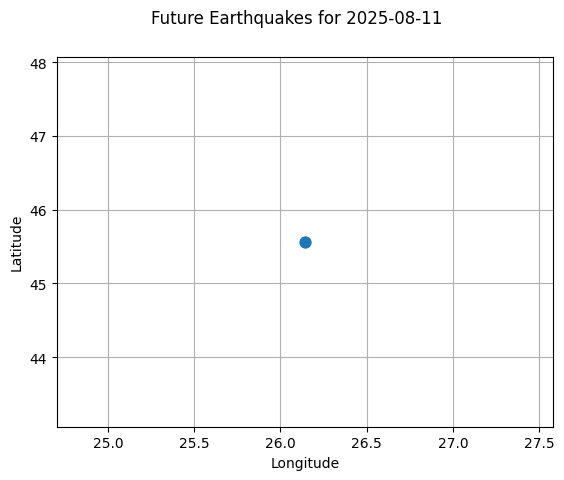

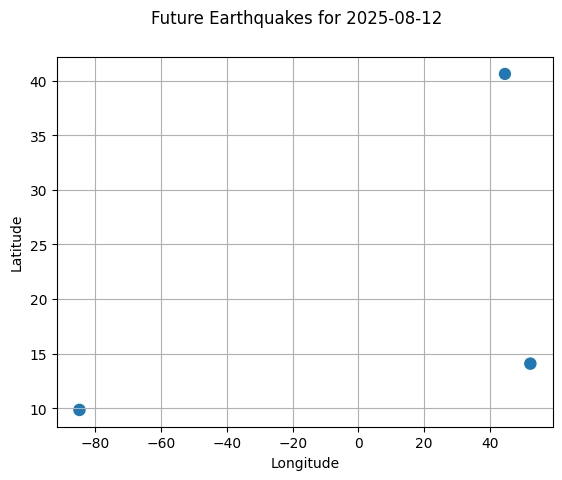

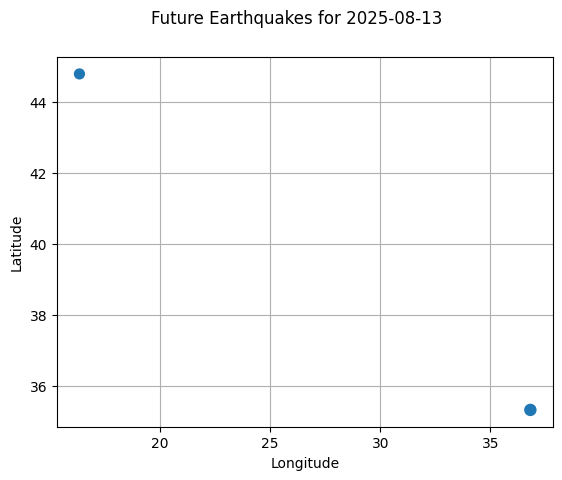

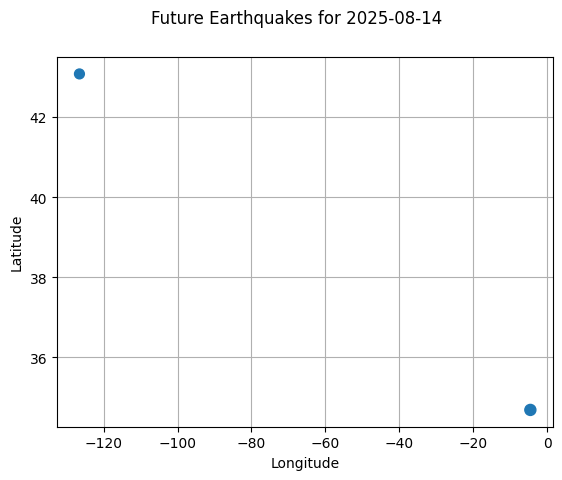

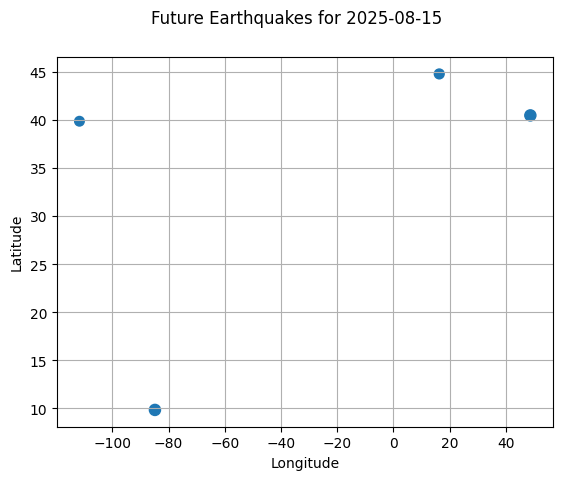

In [27]:
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

In [ ]:
import pickle

# Save model as pickle
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(bst, f)

In [ ]:
from google.colab import files
files.download('xgb_model.pkl')

In [ ]:
import pickle
import xgboost as xgb

model = xgb.train(params, dtrain, num_round)
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)
